In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
%matplotlib inline

In [2]:
#@ checking for gpu:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
data_folder='~/data/FMNIST'
fmnist=datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images=fmnist.data
tr_targets=fmnist.targets

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.5MB/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 304kB/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.55MB/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 14.8MB/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



In [4]:
class FMNISTDataset(Dataset):
  def __init__(self, x, y):
    x=x.float()/255
    x=x.view(-1, 1, 28, 28) # Batch, Channel, Height, Width
    self.x, self.y= x, y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, ix):
    x, y= self.x[ix], self.y[ix]
    return x.to(device), y.to(device)


In [5]:
#@ CNN Architecture:
from torch.optim import SGD, Adam

def get_model():
  model=nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Conv2d(64, 128, kernel_size=3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(3200, 256),
      nn.ReLU(),
      nn.Linear(256, 10)
  ).to(device)
  loss_func=nn.CrossEntropyLoss()
  optimizer=Adam(model.parameters(), lr=1e-3)
  return model, loss_func, optimizer

In [6]:
from torchsummary import summary
model, loss_func, optimizer=get_model()
summary(model, (1, 28, 28));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
         MaxPool2d-2           [-1, 64, 13, 13]               0
              ReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4          [-1, 128, 11, 11]          73,856
         MaxPool2d-5            [-1, 128, 5, 5]               0
              ReLU-6            [-1, 128, 5, 5]               0
           Flatten-7                 [-1, 3200]               0
            Linear-8                  [-1, 256]         819,456
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.69
Params size (MB): 3.42
Estimated T

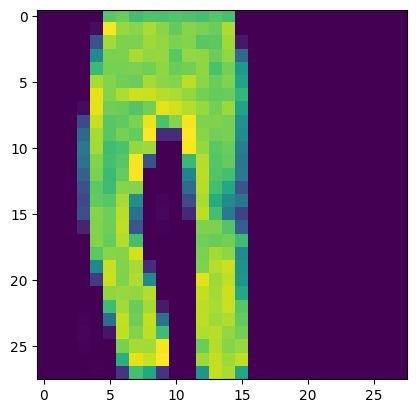

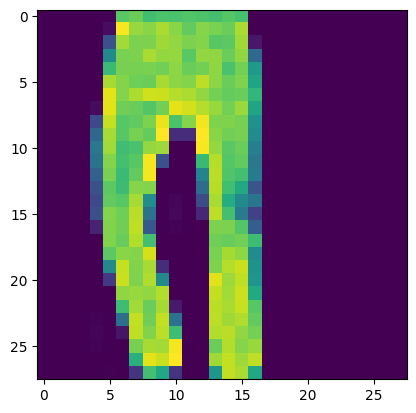

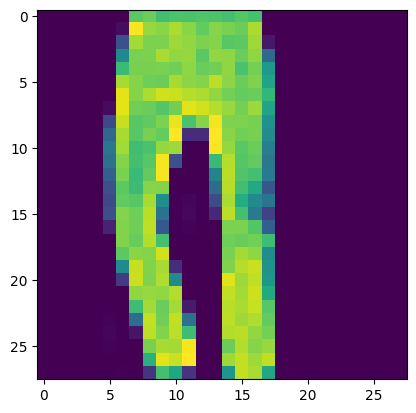

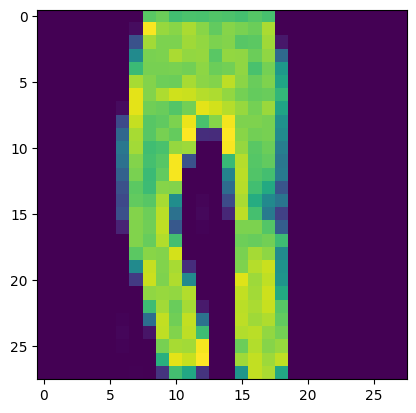

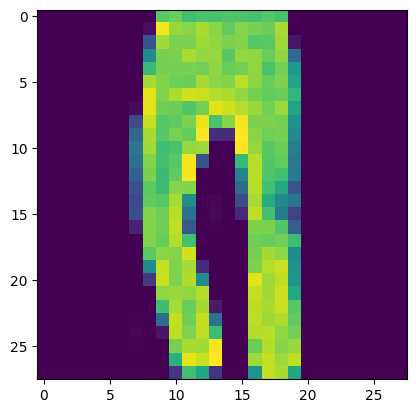

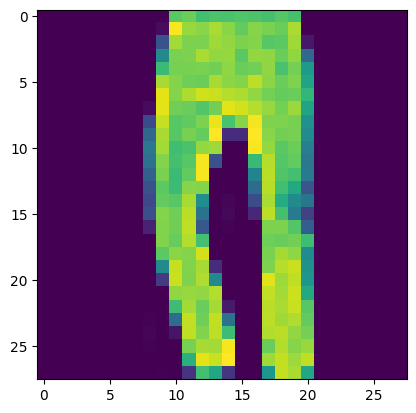

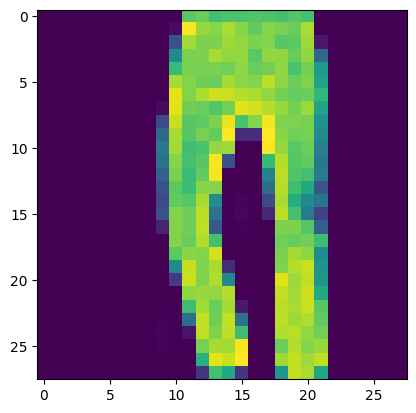

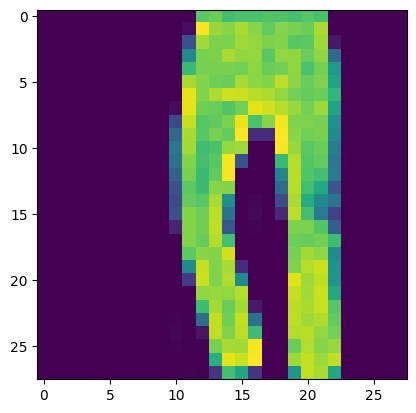

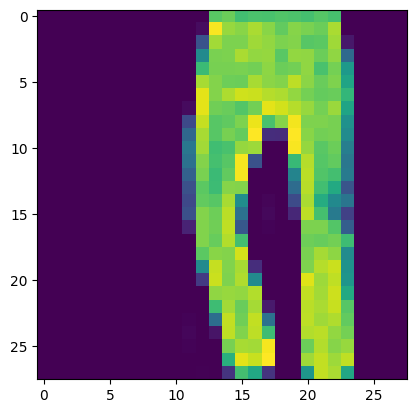

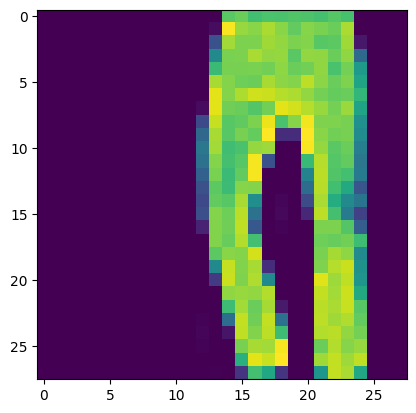

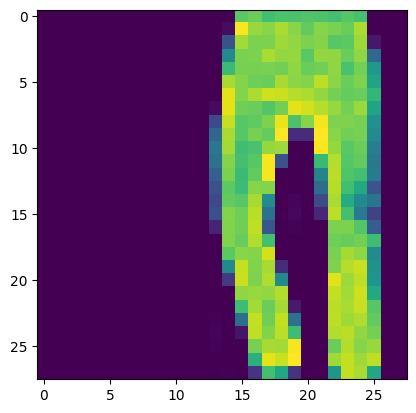

In [7]:
preds=[]

ix=24300

for px in range(-5, 6):
  img=tr_images[ix]/255.
  img=img.view(28, 28)
  img2=np.roll(img, px, axis=1)
  plt.imshow(img2)
  plt.show()

  img3=torch.Tensor(img2).view(-1, 1, 28, 28).to(device)
  np_output=model(img3).cpu().detach().numpy()
  preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

<Axes: title={'center': 'Probability of each class for various translations'}>

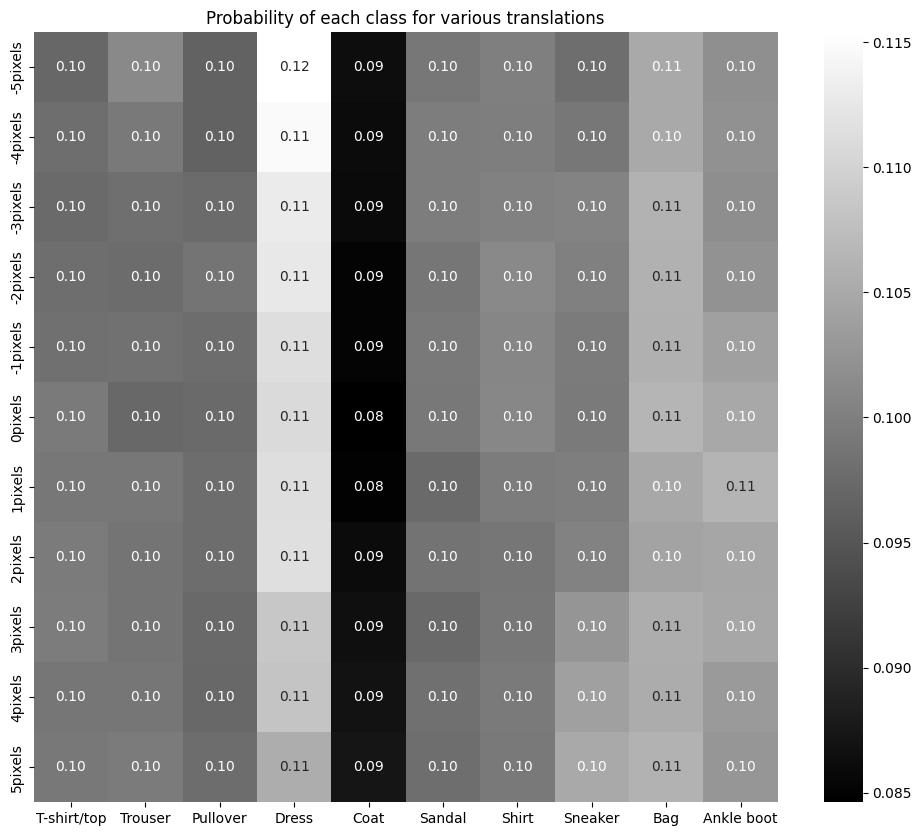

In [8]:
import seaborn as sns

fig, ax=plt.subplots(1,1, figsize=(12, 10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11, 10), annot=True,
            ax=ax, fmt='.2f', xticklabels=fmnist.classes,
            yticklabels=[str(i)+ str('pixels') for i in range(-5, 6)], cmap='gray')